In [32]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import h,c,k
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

##### Importing Datasets

In [33]:
data=fits.open('FIRAS_DESTRIPED_SKY_SPECTRA_LOWF.FITS')  
lowdust_data = fits.open("FIRAS_DUST_SPECTRUM_MAP_LOWF.FITS")


#### Contents of the dataset

In [34]:
destriped_data=data[1].data
dust_data = lowdust_data[1].data
destriped_data.columns
dust_data.columns

ColDefs(
    name = 'PIXEL'; format = '1J'
    name = 'GAL_LON'; format = '1E'; unit = 'deg'
    name = 'GAL_LAT'; format = '1E'; unit = 'deg'
    name = 'WEIGHT'; format = '1E'
    name = 'SPECTRUM'; format = '182E'; unit = 'MJy/sr'; dim = '(182)'
)

#### 1. Getting best fit temperatures for every pixel

It is observed that all the pixels have 43 workable intensity values which. This makes our job much easier
There are total of 6067 pixel data on which we need to work initially
note that it is done on the low frequency spectrum (LEFT LOW SHORT SLOW SCAN MODE OF COBE_FIRAS)

In [35]:
def Intensity(freq,T):
    e=np.exp(h*freq/(k*T))
    return (2*h*freq**3)/(c**2*(e-1))*1e20
# we multiplied with 1e20 as a method of unit conversion
    '''
    h = planck constant
    k = boltzmann constant
    c = speed of light in vacuum
    T = temperature of blackbody
    wave_num = wave number of the radiation (1/wavelength)
    '''

In [36]:
destriped_data['SPECTRUM'][0][:43:]

array([200.99837 , 250.11607 , 291.79953 , 327.67313 , 354.35162 ,
       371.71155 , 380.97324 , 382.51492 , 379.22812 , 369.41425 ,
       354.22485 , 336.02118 , 316.01633 , 294.3508  , 272.22424 ,
       249.2363  , 225.75806 , 204.64339 , 183.8708  , 164.61542 ,
       147.0386  , 130.8039  , 115.107666, 100.194725,  87.60677 ,
        75.39579 ,  65.42178 ,  58.212032,  49.86374 ,  44.60809 ,
        38.68048 ,  33.088512,  27.845034,  23.259144,  21.270378,
        18.62001 ,  14.422012,  12.399126,  13.102548,  11.390899,
         8.961309,   8.099037,  15.854761], dtype=float32)

##### Formation of a frequency array for fitting the data

In [37]:
# 1st frequency is 68.020812 Ghz
freq_0=68.020812*1e9
freq_interval=13.604162*1e9

frequency=[]
for i in range(43):
    freq_flag=freq_0+i*freq_interval
    frequency.append(freq_flag)
frequency=np.array(frequency)

FIRST WE MUST ATTAIN THE RESULTS FOR THE ORIGINAL DESTRIPED SKY SPECTRA AND SEE IF THE RESULTS ARE SATISFACTORY OR OTHERWISE


In [38]:
def get_Temperature(frequency,input):               # The best-fit function. Spits out the optimal temperature and the uncertainty
    data=dict()
    data['Temperature']=[]
    data['Uncertainty']=[]
    for i in range(len(input)):
        Intensity_observed=input[i]
        Intensity_observed=Intensity_observed[0:43:]
        T0=2
        popt,pcov=curve_fit(Intensity,frequency,Intensity_observed,p0=[T0])
        Temperature_fit=popt[0]
        Uncertainty_fit=np.sqrt(np.diag(pcov))
        data['Temperature'].append(Temperature_fit)
        data['Uncertainty'].append(Uncertainty_fit)
    return data

In [39]:
def root_mean_square(input):                          # Function to get the rms of the data
    input=np.array(input)
    squared_input=input*input
    mean=np.sum(squared_input)/squared_input.size
    return np.sqrt(mean)

In [40]:
# we will use either this or the Pixel_data['Uncertainty'] data, though i suppose we should use this because this method produces a little bit larger range of uncertainty
# this is equivalent to finding mean error
def uncertainty(input,mean):
    uncertainty_list =[]
    for i in range(len(input)):
        if input[i] > mean:
          uncertainty_list.append(input[i] - mean) 
        else:
           uncertainty_list.append(mean - input[i])
    uncertainty_array = np.array(uncertainty_list)
    return(np.mean(uncertainty_array))

In [41]:
Pixel_data=get_Temperature(frequency,destriped_data['SPECTRUM'])

#via this we have attained a dictionary which maps temperature values and respective uncertainties . 1 single mapping is equivalent to  43 value points of a pixel,
#hence we have 6067 mappings in our dictionary Pixel_data



In [42]:
avg_temperature=np.mean(Pixel_data['Temperature'])     #arithmetic mean
avg_uncertainty=uncertainty(Pixel_data['Temperature'],avg_temperature)  

root_mean_square_temperature = root_mean_square(Pixel_data['Temperature'])
standard_deviation_temperature = np.std(Pixel_data['Temperature'])

print('T in terms of arithmetic mean(Averages) = {:.6f} +- {:.6f} K'.format(avg_temperature,avg_uncertainty))
print('T in terms of root mean square values = {:.6f} +- {:.6f} K'.format(root_mean_square_temperature,standard_deviation_temperature))


T in terms of arithmetic mean(Averages) = 2.729850 +- 0.002725 K
T in terms of root mean square values = 2.729854 +- 0.004647 K


AS WE CAN SEE THE CMB TEMPERATURE VALUE OBTAINED BY SIMPLY USING THE DESTRIPED DATA IS HIGHLY DEVIATED FROM WHAT IT SHOULD BE.

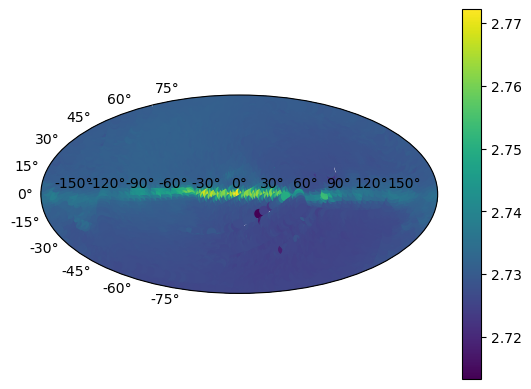

In [43]:
'''The data given in the cobe_firas sites of longitudes has the conventional range of 0 degrees to 360 degrees. The resultant map which need to be produced follows
the convention of -180 degrees to 180 degrees'''

longitude=[]
for i in destriped_data['GAL_LON']:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)

# DEGREES TO RADIANS CONVERSION

latitude_rad=np.pi*destriped_data['GAL_LAT']/180
longitude_rad=np.pi*np.array(longitude)/180

plt.figure()
plt.subplot(111,projection='aitoff')
#plt.scatter(longitude_rad,latitude_rad,c=Pixel_data['Temperature'],cmap='plasma',norm=LogNorm(vmax=np.nanmax(Pixel_data['Temperature'])))
plt.scatter(longitude_rad,latitude_rad,c=np.array(Pixel_data['Temperature']))
plt.colorbar()

BECAUSE THE VALUE AND THE MAP ARE NOT SATISFACTORY WE WILL USE SOME TECHNIQUES AS DONE BELOW

DUST SPECTRUM REMOVAL-
THE DESTRIPED DATA WHICH WE USE IS HIGHLY CONTAMINATED ,THE ABSOLUTE INTENSITIES ARE DISRUPTED BY THE EMISSION OF EM RADIATION DUE TO MANY GALACTIC AND OTHER ENTITIES ,A MAJOR SET OF ENTITIES OF THAT SORT IS THE COSMIC DUST .
OUR GOAL IS TO REMOVE ALL THE DUST COMPONENTS FROM THE DESTRIPED SKY SPECTRA 

In [44]:
# We now tend to attain an array with a better data  - dust removed data

final_data = [i*0 for i in range(0,6067)]
dust_clear_data = destriped_data['SPECTRUM'] -dust_data['SPECTRUM']
for i in range(len(dust_clear_data)):
    final_data[i] = dust_clear_data[i][:43:] + final_data[i]
Pixel_data=get_Temperature(frequency,final_data)

    

avg_temperature=np.mean(Pixel_data['Temperature'])
avg_uncertainty=uncertainty(Pixel_data['Temperature'],avg_temperature)
root_mean_square_temperature = root_mean_square(Pixel_data['Temperature'])
standard_deviation_temperature = np.std(Pixel_data['Temperature'])

print('Arithmetic mean temperature(Average temperature) = {:.6f} +- {:.6f} K'.format(avg_temperature,avg_uncertainty))
print('Root mean square temperature = {:.6f} +- {:.6f} K'.format(root_mean_square_temperature,standard_deviation_temperature))



KeyboardInterrupt: 

As a control setup we also work on the data with no dust removal side by side with the one with removed dust so as to compare the two sets of values and maps we obtain

In [ ]:
final_data_control = [i*0 for i in range(0,6067)]
for i in range(len(destriped_data['SPECTRUM'])):
    final_data_control[i] = destriped_data['SPECTRUM'][i][:43:] + final_data_control[i]
Pixel_data_control = get_Temperature(frequency,final_data_control)

avg_temperature_control =np.mean(Pixel_data_control['Temperature'])
avg_uncertainty_control =uncertainty(Pixel_data_control['Temperature'],avg_temperature_control)
rms_temperature_control = root_mean_square(Pixel_data_control['Temperature'])
standard_deviation_temperature_control = np.std(Pixel_data_control['Temperature'])

print('Arithmetic mean temperature(Average temperature)_control = {:.6f} +- {:.6f} K'.format(avg_temperature_control,avg_uncertainty_control))
print('Root mean square temperature_control = {:.6f} +- {:.6f} K'.format(rms_temperature_control,standard_deviation_temperature_control))



Arithmetic mean temperature(Average temperature)_control = 2.729850 +- 0.002725 K
Root mean square temperature_control = 2.729854 +- 0.004647 K


GALACTIC CUTTING -
THE GALAXY EMISSION(EM WAVES EMITTED BY STARS AND OTHER OBJECTS IN AND AROUND THE GALAXY) CAUSES OUR CMB TEMPERATURE VALUE TO DEVIATE
AS CMB IS INDEPENDENT OF THE PRESENCE OF ANY PHYSICAL OBJECT IN PRESENT UNIVERSE WHICH  CAN EMIT EM RADIATION
HENCE TO OBTAIN BETTER APPROXIMATION OF CMB WE CONSIDER REMOVING THOSE PIXELS FROM OUR WORKING SET OF PIXELS WHICH HAVE HUGE GALACTIC CONTAMINATION IN THEIR DATA.

In [56]:
#NO NEED TO PANIC GUYS ;)  IT JUST LOOKS COMPLICATED - SANATAN   , just keep in mind that we are working on two data sets - control dataset and experimental dataset

latitude = destriped_data['GAL_LAT']
longitude=destriped_data['GAL_LON']
Intensity_observed = final_data
Intensity_observed_control = final_data_control
i=[]
accepted_spectrum=[]
accepted_spectrum_control =[]
galactic_cut_latitude=[]
galactic_cut_longitude=[]


for i in range(0,len(latitude)):
    if latitude[i] < 15:
        if latitude[i] >-15:
            continue
        else:
            accepted_spectrum.append(Intensity_observed[i])
            accepted_spectrum_control.append(Intensity_observed_control[i])
            galactic_cut_latitude.append(latitude[i])
            galactic_cut_longitude.append(longitude[i])
    if latitude[i]>15:
        accepted_spectrum.append(Intensity_observed[i])
        accepted_spectrum_control.append(Intensity_observed_control[i])
        galactic_cut_latitude.append(latitude[i])
        galactic_cut_longitude.append(longitude[i])
spectrum_cut=np.array(accepted_spectrum)
spectrum_cut_control = np.array(accepted_spectrum_control)
spectrum_cut.shape
#spectrum_cut_control.shape

# latitude and longitude lists are compatible for working on both experimental dataset(dust removed data) and control dataset(original data)

#just for reference. remove the hashtag to observe the respective arrays
#print(spectrum_cut)
#print(spectrum_cut_control)

(4514, 43)

In [52]:
#NO NEED TO PANIC GUYS ;)  IT JUST LOOKS COMPLICATED - SANATAN   , just keep in mind that we are working on two data sets - control dataset and experimental dataset

latitude = destriped_data['GAL_LAT']
longitude=destriped_data['GAL_LON']
Intensity_observed = final_data
Intensity_observed_control = final_data_control
i=[]
accepted_spectrum=np.empty(0)
accepted_spectrum_control =np.empty(0)
galactic_cut_latitude=np.empty(0)
galactic_cut_longitude=np.empty(0)


for i in range(0,len(latitude)):
    if latitude[i] < 15:
        if latitude[i] >-15:
            continue
        else:
            np.append(accepted_spectrum,Intensity_observed[i])
            np.append(accepted_spectrum_control,Intensity_observed_control[i])
            np.append(galactic_cut_latitude,latitude[i])
            np.append(galactic_cut_longitude,longitude[i])
    if latitude[i]>15:
        np.append(accepted_spectrum,Intensity_observed[i])
        np.append(accepted_spectrum_control,Intensity_observed_control[i])
        np.append(galactic_cut_latitude,latitude[i])
        np.append(galactic_cut_longitude,longitude[i])
spectrum_cut=np.array(accepted_spectrum)
spectrum_cut_control = np.array(accepted_spectrum_control)
spectrum_cut.shape
spectrum_cut_control.shape

# latitude and longitude lists are compatible for working on both experimental dataset(dust removed data) and control dataset(original data)

#just for reference. remove the hashtag to observe the respective arrays
#print(spectrum_cut)
#print(spectrum_cut_control)

(0,)

In [ ]:
longitude=[]
for i in galactic_cut_longitude:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
galactic_cut_latitude=np.array(galactic_cut_latitude)
galactic_cut_longitude=np.array(longitude)

In [ ]:
# THIS SUB_CODEBLOCK IS FOR EXPERIMENTAL DATASET
Pixel_cut = get_Temperature(frequency,spectrum_cut)

avg_temperature=np.mean(Pixel_cut['Temperature'])
avg_uncertainty=uncertainty(Pixel_cut['Temperature'],avg_temperature)
root_mean_square_temperature = root_mean_square(Pixel_cut['Temperature'])
standard_deviation = np.std(Pixel_cut['Temperature'])
print('Arithmetic mean temperature(Average temperature) = {:.6f} +- {:.6f} K'.format(avg_temperature,avg_uncertainty))
print('Root mean square temperature = {:.6f} +- {:.6f} K'.format(root_mean_square_temperature,standard_deviation_temperature))


'''.........................................................................................................................................................................'''


# THIS SUB-CODEBLOCK IS FOR CONTROL DATASET
Pixel_cut_control = get_Temperature(frequency,spectrum_cut_control)

avg_temperature_control =np.mean(Pixel_cut_control['Temperature'])
avg_uncertainty_control =uncertainty(Pixel_cut_control['Temperature'],avg_temperature_control)
rms_temperature_control = root_mean_square(Pixel_cut_control['Temperature'])
standard_deviation_control = np.std(Pixel_cut_control['Temperature'])
print('Arithmetic mean temperature(Average temperature)_control = {:.6f} +- {:.6f} K'.format(avg_temperature_control,avg_uncertainty_control))
print('Root mean square temperature_control = {:.6f} +- {:.6f} K'.format(rms_temperature_control,standard_deviation_temperature_control))
#print(Pixel_cut_control['Temperature'])
#print(Pixel_cut['Temperature])

Arithmetic mean temperature(Average temperature) = 2.727816 +- 0.001683 K
Root mean square temperature = 2.727816 +- 0.001948 K
Arithmetic mean temperature(Average temperature)_control = 2.729850 +- 0.002725 K
Root mean square temperature_control = 2.729854 +- 0.004647 K


CLEARLY CUT ALONG THE GALACTIC EQUATOR AS DONE ABOVE IS NOT ADEQUATE,THERE IS STILL DEVIATION WE WOULD LIKE TO GET RID OF.
ANY PIXEL WITH MORE THAN 5*SIGMA DEVIATION(SIGMA IS THE RMS VALUE OF FINAL TEMPERATURES COMPUTED TILL NOW) FROM THE AVERAGE SHOULD BE DROPPED FROM THE ANALYSIS


In [ ]:
sigma_corrected_data=[]
galactic_cut_longitude.tolist()
galactic_cut_latitude.tolist()
final_latitude = []
final_longitude = []

sigma = np.std(Pixel_cut['Temperature'])
for i in range(len(Pixel_cut['Temperature'])):
    point_max=avg_temperature +5*sigma
    point_min=avg_temperature -5*sigma
    if Pixel_cut['Temperature'][i] < point_max:
        if Pixel_cut['Temperature'][i]>=point_min:
            sigma_corrected_data.append(Pixel_cut['Temperature'][i])
            final_longitude.append(galactic_cut_longitude[i])
            final_latitude.append(galactic_cut_latitude[i])
sigma_corrected_data=np.array(sigma_corrected_data)


sigma_corrected_data_control=[]
final_latitude_control = []
final_longitude_control = []

sigma = np.std(Pixel_cut['Temperature'])
for i in range(len(Pixel_cut_control['Temperature'])):
    point_max=avg_temperature +5*sigma
    point_min=avg_temperature -5*sigma
    if Pixel_cut_control['Temperature'][i] < point_max:
        if Pixel_cut_control['Temperature'][i]>=point_min:
            sigma_corrected_data_control.append(Pixel_cut_control['Temperature'][i])
            final_longitude_control.append(galactic_cut_longitude[i])
            final_latitude_control.append(galactic_cut_latitude[i])
sigma_corrected_data_control=np.array(sigma_corrected_data_control)



NameError: name 'galactic_cut_longitude' is not defined

TEMPERATURES ARE IN TWO FORMS ONE IS DERIVED FROM THE AVERAGE METHOD AND THE OTHER VIA ROOT MEAN SQUARE METHOD

In [ ]:

avg_temperature_final = np.mean(sigma_corrected_data)
root_mean_square_temperature_final = root_mean_square(sigma_corrected_data)
avg_uncertainty_final = uncertainty(sigma_corrected_data,avg_temperature_final)
standard_deviation_final = np.std(sigma_corrected_data)

print('After 5$\sigma$ correction of the dataset,')
print('Arithmetic mean temperature(Average temperature)_final = {:.6f} +- {:.6f} K'.format(avg_temperature_final,avg_uncertainty_final))
print('Root mean square temperature_final = {:.6f} +- {:.6f} K'.format(root_mean_square_temperature_final,standard_deviation_final))

'''........................................................................................................................................................................'''

avg_temperature_final_control = np.mean(sigma_corrected_data_control)
root_mean_square_temperature_final_control = root_mean_square(sigma_corrected_data_control)
avg_uncertainty_final_control = uncertainty(sigma_corrected_data_control,avg_temperature_final_control)
standard_deviation_final_control = np.std(sigma_corrected_data_control)

print('Arithmetic mean temperature(Average temperature)_final_control = {:.6f} +- {:.6f} K'.format(avg_temperature_final_control,avg_uncertainty_final_control))
print('Root mean square temperature_final_control = {:.6f} +- {:.6f} K'.format(root_mean_square_temperature_final_control,standard_deviation_final_control))



Arithmetic mean temperature(Average temperature)_final = 2.727816 +- 0.001683 K
Root mean square temperature_final = 2.727816 +- 0.001948 K


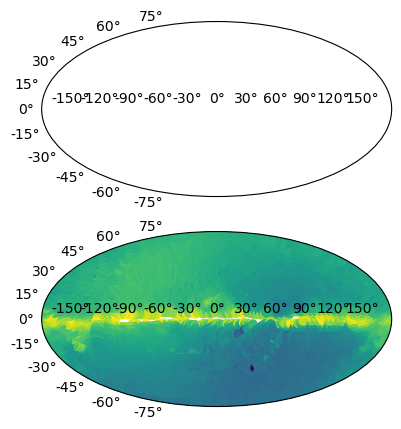

In [45]:
# This subcode_block is for the experimental dataset        DUST REMOVED SPECTRA
longitude=[]
for i in final_longitude:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
latitude=final_latitude
latitude_rad=np.pi*np.array(final_latitude)/180
longtitude_rad=np.pi*np.array(final_longitude)/180
fig=plt.figure()
ax1=fig.add_subplot(211,projection='aitoff')
ax1.scatter(longtitude_rad,latitude_rad,c=sigma_corrected_data)
'''........................................................................................................................................................................'''
# This subcode_block is for the control dataset             NO-DUST-REMOVAL 
longitude=[]
for i in final_longitude_control:
    if i > 180:
        longitude.append(i-360)
    else:
        longitude.append(i)
latitude=final_latitude_control
latitude_rad_control=np.pi*np.array(final_latitude_control)/180
longtitude_rad_control=np.pi*np.array(final_longitude_control)/180

ax2=fig.add_subplot(212,projection='aitoff')
ax2.scatter(longtitude_rad_control,latitude_rad_control,c=sigma_corrected_data_control)

In [ ]:
#Code to calculate angle between two given galactic coordinate vectors
'''import math as mt
def vector(l,b):
  a=mt.radians(l)
  b=mt.radians(b)
  x=mt.cos(a)*mt.cos(b)
  y=mt.sin(a)*mt.cos(b)
  z=mt.sin(b)
  vect=[x,y,z]
  return vect


l1=int(input("Enter first longitude angle in degrees: "))
b1=int(input("Enter first latitude angle in degrees: "))
l2=int(input("Enter second longitude angle in degrees: "))  
b2=int(input("Enter second latitude angle in degrees: "))

def dotprod(A,B):
  x=0
  for i in range(0,len(A)):
    x+=A[i]*B[i]
  return x
A = vector(l1,b1)
B = vector(l2,b2)
magsqrA=0
magsqrB=0
for i in A:
  magsqrA+=i*i
for j in B:
  magsqrB+=j*j

magnitudeA=mt.sqrt(magsqrA)
print(magnitudeA)
magnitudeB=mt.sqrt(magsqrB)
print(magnitudeB)
print(magnitudeA*magnitudeB)

def theta(A,B):
  thetarad=mt.acos(dotprod(A,B)/(magnitudeA*magnitudeB))
  thetadeg=mt.degrees(thetarad)
  return thetarad
A=vector(l1,b1)
B=vector(l2,b2)

theta(A,B)'''

'import math as mt\ndef vector(l,b):\n  a=mt.radians(l)\n  b=mt.radians(b)\n  x=mt.cos(a)*mt.cos(b)\n  y=mt.sin(a)*mt.cos(b)\n  z=mt.sin(b)\n  vect=[x,y,z]\n  return vect\n\n\nl1=int(input("Enter first longitude angle in degrees: "))\nb1=int(input("Enter first latitude angle in degrees: "))\nl2=int(input("Enter second longitude angle in degrees: "))  \nb2=int(input("Enter second latitude angle in degrees: "))\n\ndef dotprod(A,B):\n  x=0\n  for i in range(0,len(A)):\n    x+=A[i]*B[i]\n  return x\nA = vector(l1,b1)\nB = vector(l2,b2)\nmagsqrA=0\nmagsqrB=0\nfor i in A:\n  magsqrA+=i*i\nfor j in B:\n  magsqrB+=j*j\n\nmagnitudeA=mt.sqrt(magsqrA)\nprint(magnitudeA)\nmagnitudeB=mt.sqrt(magsqrB)\nprint(magnitudeB)\nprint(magnitudeA*magnitudeB)\n\ndef theta(A,B):\n  thetarad=mt.acos(dotprod(A,B)/(magnitudeA*magnitudeB))\n  thetadeg=mt.degrees(thetarad)\n  return thetarad\nA=vector(l1,b1)\nB=vector(l2,b2)\n\ntheta(A,B)'

In [ ]:
def deg_rad(deg):
    rad = np.pi * deg/180
    return rad
def costheta(l1,b1,l2,b2):
    l1=deg_rad(l1)
    b1=deg_rad(b1)
    l2=deg_rad(l2)
    b2=deg_rad(b2)
    a=np.cos(b1)*np.cos(l1)*np.cos(b2)*np.cos(l2)
    b=np.sin(b1)*np.sin(l1)*np.cos(b2)*np.sin(l2)
    c=np.sin(b1)*np.sin(b2)
    return a+b+c